In [48]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from pathlib import Path
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [50]:
data_dir = Path("/kaggle/input/brainmetshare-npy/BrainMetShare_npy")

### U-NET Model

- Consider adding batchnorm to doubleConv

In [51]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        return x

- consider adding other encoder layer

In [52]:
class UNETModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Down
        self.down1 = DoubleConv(in_channels,64)
        self.down2 = DoubleConv(64,128)
        self.down3 = DoubleConv(128,256)
        self.bottleneck = DoubleConv(256,512)

        self.pool = nn.MaxPool2d(2)

        # Up
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.right1 = DoubleConv(512, 256) # 256 (up) + 256 (encoder3)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.right2 = DoubleConv(256, 128) # 128 (up) + 128 (encoder2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.right3 = DoubleConv(128, 64) # 64 (up) + 64 (encoder1)

        # Out
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Down
        encoder1 = self.down1(x)
        encoder2 = self.down2(self.pool(encoder1))
        encoder3 = self.down3(self.pool(encoder2))

        # Bottleneck
        bneck = self.bottleneck(self.pool(encoder3))

        # Up
        decoder1 = self.up1(bneck)
        decoder1 = self.right1(torch.cat([decoder1, encoder3], dim=1))
        decoder2 = self.up2(decoder1)
        decoder2 = self.right2(torch.cat([decoder2, encoder2], dim=1))
        decoder3 = self.up3(decoder2)
        decoder3 = self.right3(torch.cat([decoder3, encoder1], dim=1))

        # Out
        out = self.out(decoder3)
        return out


### Preparing Data

In [53]:
def largest_slice(mask):
    slice_sums = mask.sum(axis=(0, 1))
    z = int(np.argmax(slice_sums))
    return z

In [54]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class MRIDataset(Dataset):
    def __init__(self, dir_list):
        self.sample_dirs = dir_list  # Already a list of Path objects

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        image = np.load(sample_dir / "image_t1.npy")
        mask = np.load(sample_dir / "mask.npy")

        # Take slice
        z = largest_slice(mask)
        image = image[:,:,z]
        mask = mask[:,:,z]

        # Conver to tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask, sample_dir.name

In [55]:
from sklearn.model_selection import train_test_split

# Split data into train and test
dirs = sorted([p for p in data_dir.iterdir() if p.is_dir()])
train_dirs, test_dirs = train_test_split(dirs, test_size=0.2, random_state=12)
train_data = MRIDataset(train_dirs)
test_data = MRIDataset(test_dirs)

In [56]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

- Add dice loss to criterion

In [57]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid to logits
        probs = torch.sigmoid(logits)
        targets = targets.float()

        intersection = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()



In [58]:
def combined_loss(logits, targets):
    return DiceLoss()(logits, targets) + nn.BCEWithLogitsLoss()(logits, targets)

In [59]:
def safe_dice_loss(logits, targets, smooth=1e-6):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    valid = targets.sum(dim=(2, 3)) > 0  # skip blank targets
    intersection = (probs * targets).sum(dim=(2, 3))
    union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice[valid].mean() if valid.any() else torch.tensor(0.0, device=logits.device)

In [60]:
model = UNETModel().to(device)
criterion = combined_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 50
train_losses = [0] * epochs
test_losses = [0] * epochs
for i in range(epochs):
    model.train()
    train_loss_total = 0
    for b, (img_train, mask_train, names) in enumerate(train_loader):
        img_train = img_train.to(device)
        mask_train = mask_train.to(device)

        mask_pred = model(img_train)
        loss = criterion(mask_pred, mask_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()
        print(f'Epoch: {i+1} Batch: {b+1} Loss: {loss.item()}')

    train_losses[i] = train_loss_total / len(train_loader)

    # testing
    model.eval()
    test_loss_total = 0
    with torch.no_grad():
        for b, (img_test, mask_test, names) in enumerate(test_loader):
            img_test = img_train.to(device)
            mask_test = mask_train.to(device)

            mask_pred = model(img_test)
            loss = criterion(mask_pred, mask_test)
            test_loss_total += loss.item()

    test_losses[i] = test_loss_total / len(test_loader)

Epoch: 1 Batch: 1 Loss: 1.7045254707336426
Epoch: 1 Batch: 2 Loss: 1.7020106315612793
Epoch: 1 Batch: 3 Loss: 1.6951673030853271
Epoch: 1 Batch: 4 Loss: 1.6945756673812866
Epoch: 1 Batch: 5 Loss: 1.6904462575912476
Epoch: 1 Batch: 6 Loss: 1.6759132146835327
Epoch: 1 Batch: 7 Loss: 1.6808228492736816
Epoch: 1 Batch: 8 Loss: 1.6726819276809692
Epoch: 1 Batch: 9 Loss: 1.6673128604888916
Epoch: 1 Batch: 10 Loss: 1.666649341583252
Epoch: 1 Batch: 11 Loss: 1.6609842777252197
Epoch: 1 Batch: 12 Loss: 1.6528065204620361
Epoch: 1 Batch: 13 Loss: 1.6518189907073975
Epoch: 1 Batch: 14 Loss: 1.6405985355377197
Epoch: 1 Batch: 15 Loss: 1.631679654121399
Epoch: 1 Batch: 16 Loss: 1.615952491760254
Epoch: 1 Batch: 17 Loss: 1.6145710945129395
Epoch: 1 Batch: 18 Loss: 1.5975406169891357
Epoch: 1 Batch: 19 Loss: 1.569894552230835
Epoch: 1 Batch: 20 Loss: 1.5490961074829102
Epoch: 1 Batch: 21 Loss: 1.5017073154449463
Epoch: 2 Batch: 1 Loss: 1.47992742061615
Epoch: 2 Batch: 2 Loss: 1.4384653568267822
Epoch

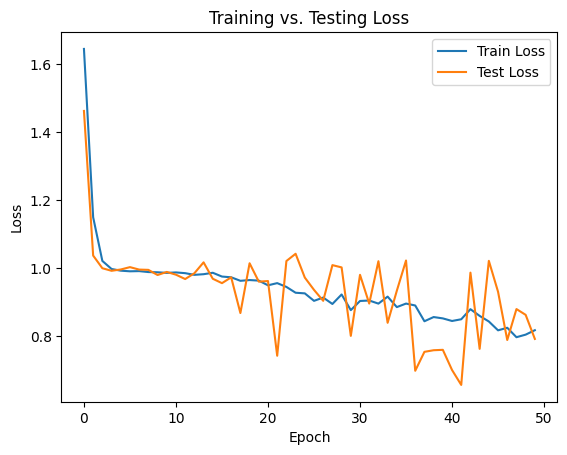

In [61]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Testing Loss')
plt.legend()

In [62]:
def plot_predictions_grid(images, masks, preds, names=None, max_rows=5, threshold=0.5):
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = torch.sigmoid(preds).cpu().numpy()
    preds = (preds > threshold).astype(float)

    num = min(len(images), max_rows)
    plt.figure(figsize=(12, 3 * num))

    for i in range(num):
        name = names[i] if names is not None else f"Image {i}"

        # Original MRI
        plt.subplot(num, 3, 3 * i + 1)
        plt.imshow(images[i, 0], cmap='gray')
        plt.title(f"{name} (MRI)")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num, 3, 3 * i + 2)
        plt.imshow(masks[i, 0], cmap='Reds')
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num, 3, 3 * i + 3)
        plt.imshow(preds[i, 0], cmap='Blues')
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


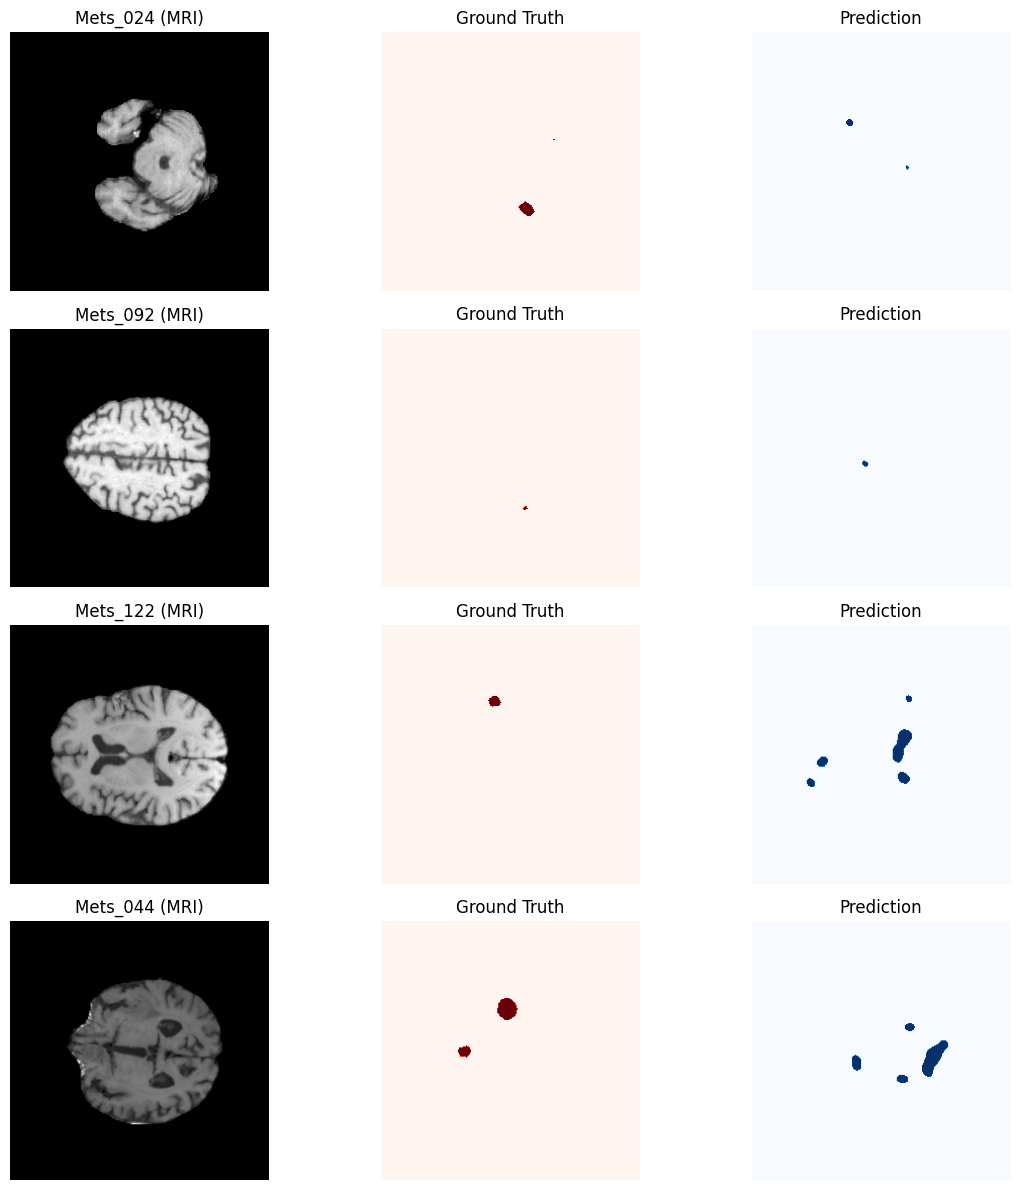

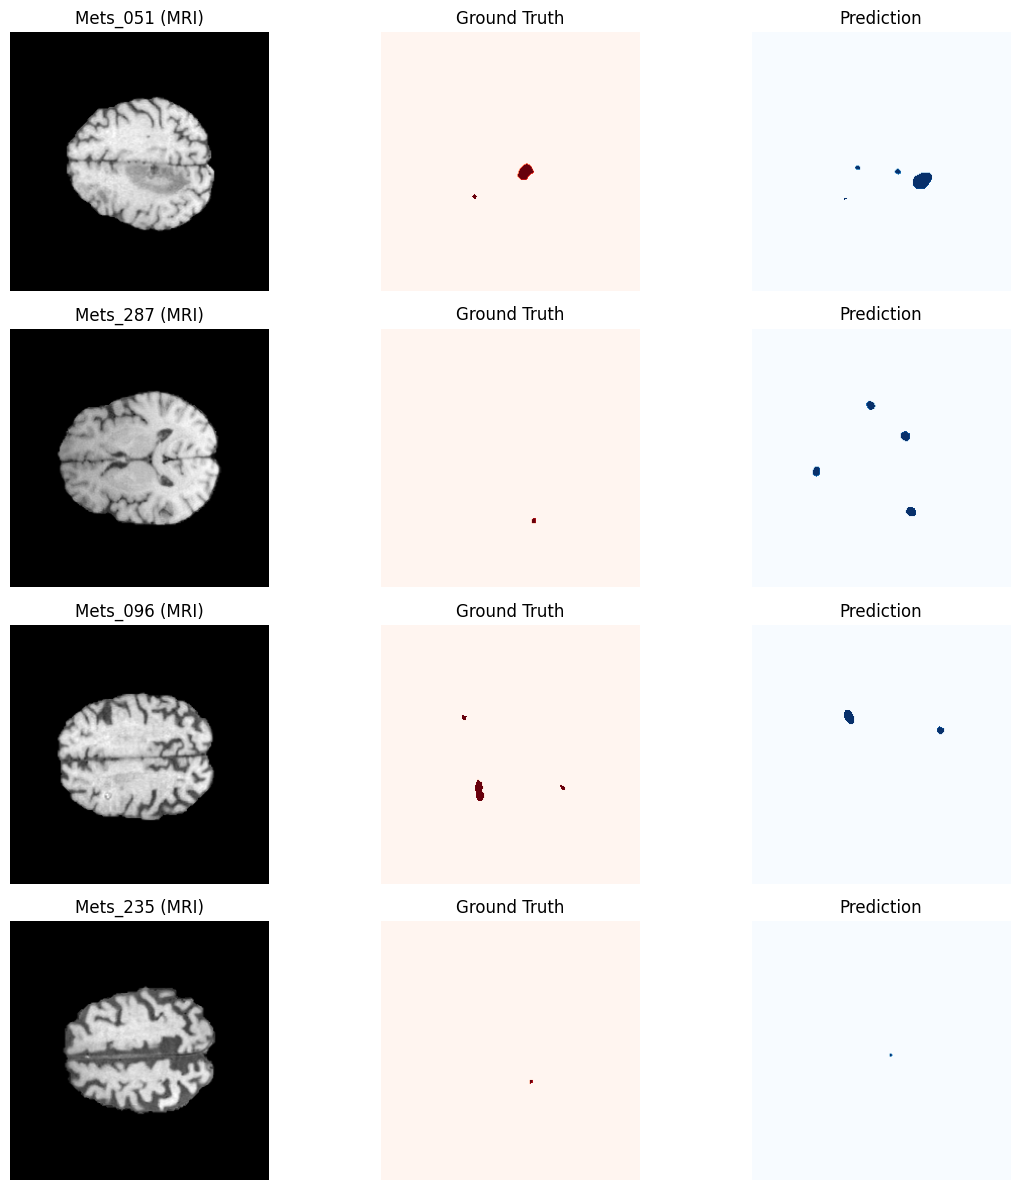

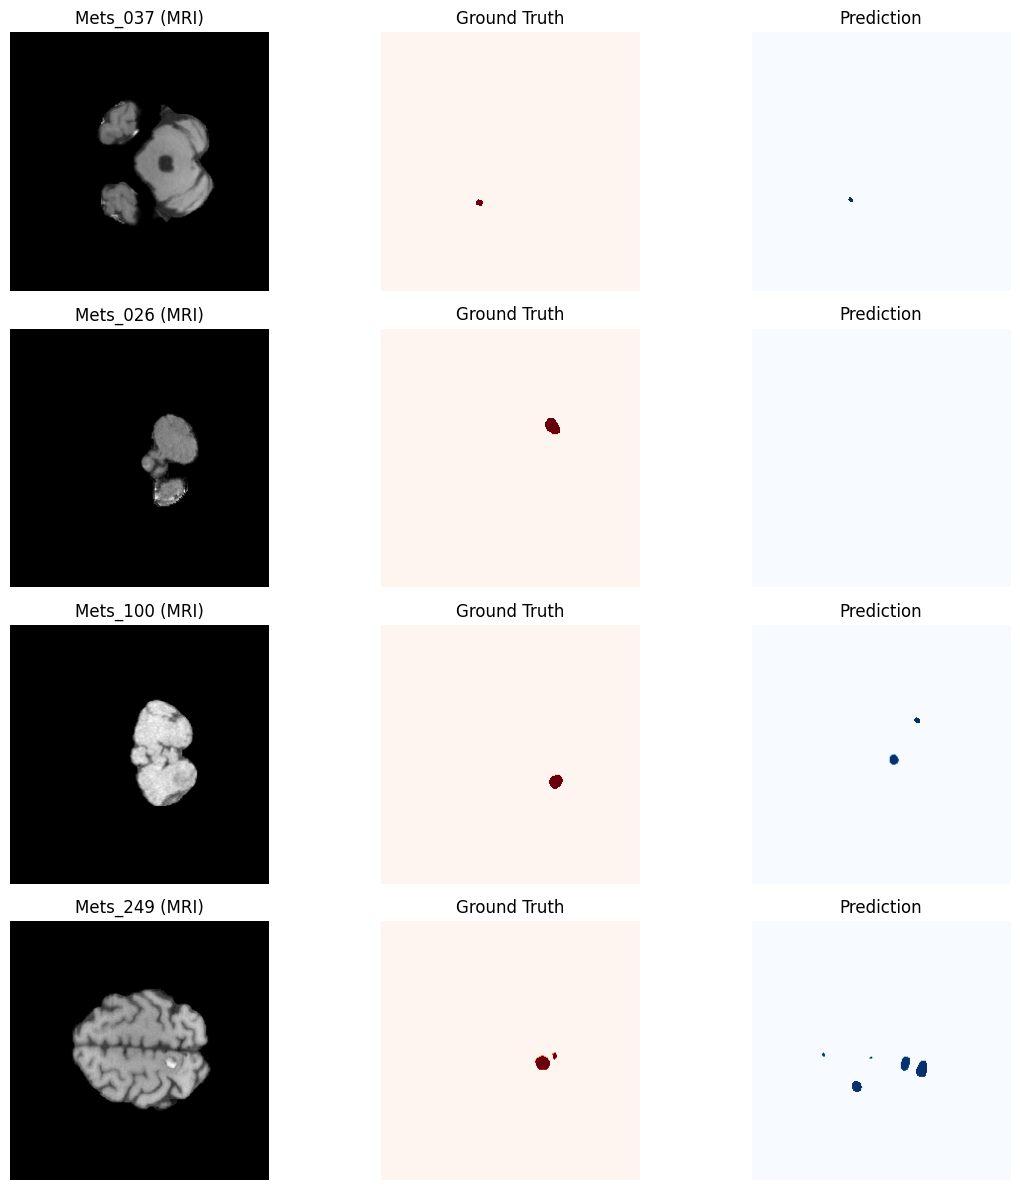

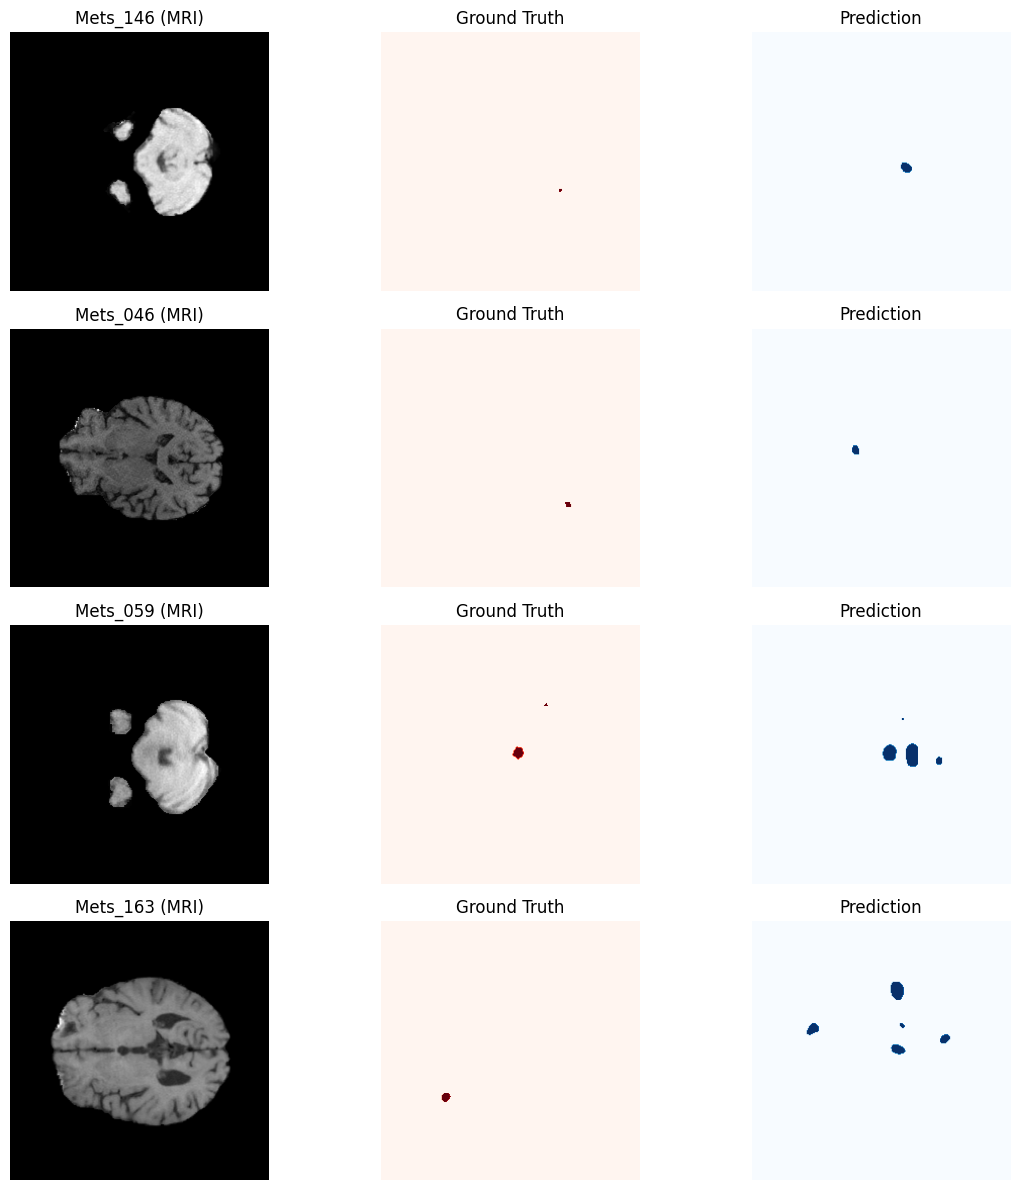

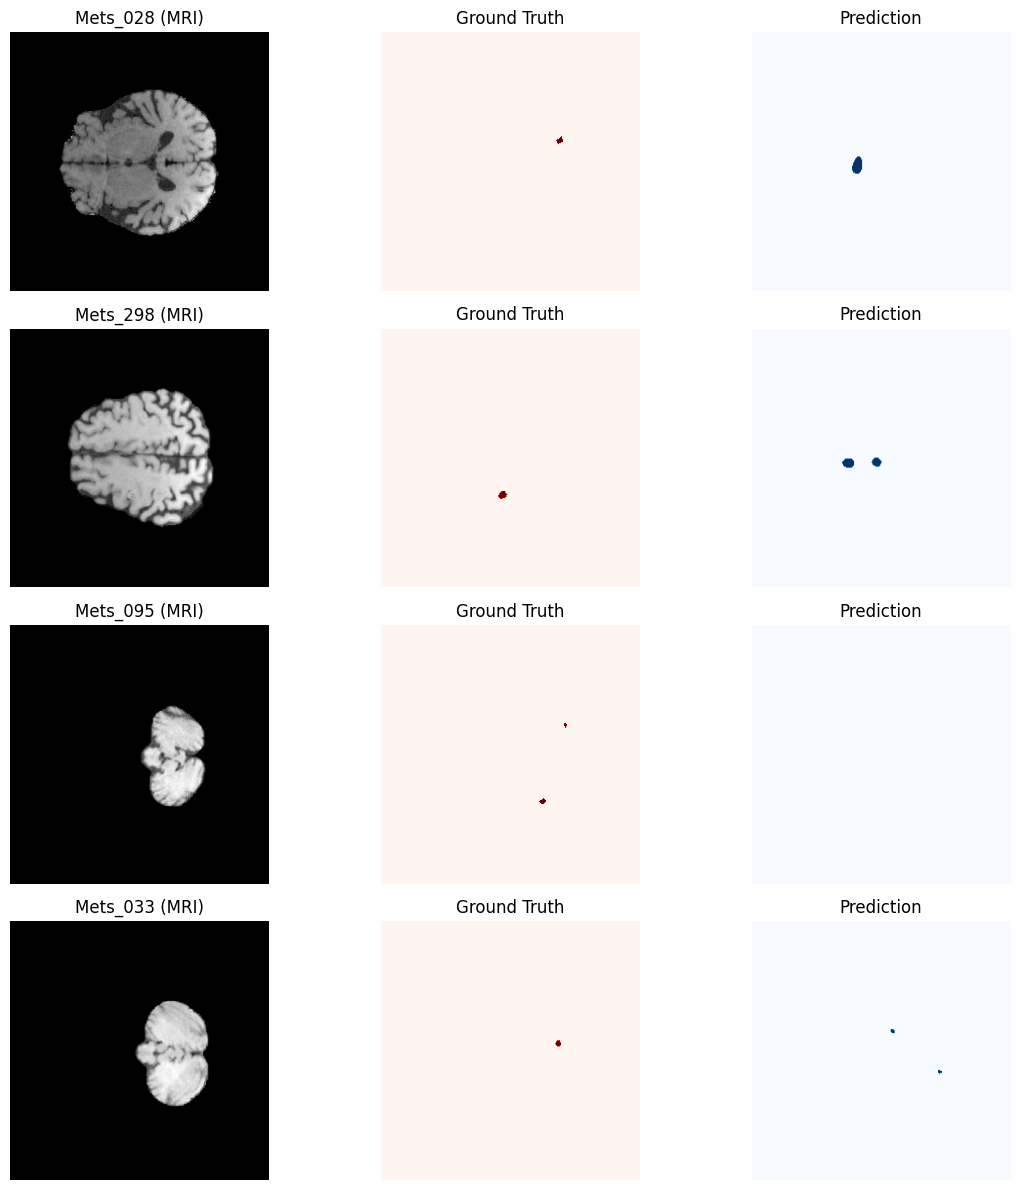

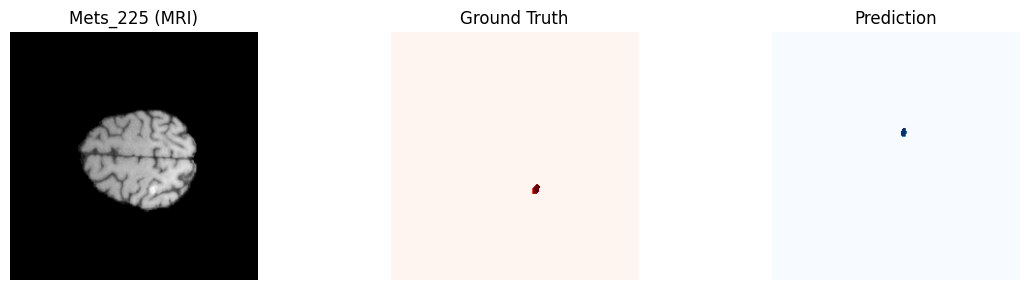

In [63]:
model.eval()
with torch.no_grad():
    for img_batch, mask_batch, names in test_loader:
        img_batch = img_batch.to(device)
        preds = model(img_batch)
        plot_predictions_grid(img_batch, mask_batch, preds, names, max_rows=6, threshold=0.5)
        # remove break if you want to loop through all batches


In [64]:
model.eval()
with torch.no_grad():
    img, mask, name = test_data[0]
    pred = model(img.unsqueeze(0).to(device))
    print(torch.sigmoid(pred).min().item(), torch.sigmoid(pred).max().item())

9.979670735627e-12 0.9064816832542419
